In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn

In [ ]:
mot_dir = "/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/train"
print(os.listdir(mot_dir))

In [ ]:

def get_tracklet(gt_in, object_id):
    """
    Extract the tracklet for a given object ID.
    :param df: DataFrame containing the ground truth data.
    :param object_id: The ID of the object to extract the tracklet for.
    :return: DataFrame containing the tracklet.
    """
    tracklet  = []
    # tracklet.append(i) [for i in gt_in if gt_in[i] == object_id]
    for i in gt_in:
        # print(i)
        if i[1] == object_id:
            tracklet.append(i[2:6])
    return np.array(tracklet)

def tokenizer_frames(tracking, sliding_window):
    
    token  = [] 
    for i in range(sliding_window):
        current_bbox = tracking[i]
        # print("bounding box at {} frame : {}".format(i,current_bbox))
        # print("tracklet at Nth place is : ", tracking[sliding_window])
        delta = np.subtract(tracking[sliding_window], current_bbox)
        # print("delta is : ", delta)
        token.append(delta)
    
    return np.array(token)


for sequence in os.listdir(mot_dir):
    # seq = os.path.join(mot_dir, sequence)
    image_dir = os.path.join(mot_dir, sequence, "img1")
    gt_file = os.path.join(mot_dir, sequence, "gt", "gt.txt")
    # print(gt_file)

    gt_in = np.loadtxt(gt_file, delimiter = ",")

    # print(gt_in)

    ## Lets define 1 tracklet first
    object_id = 2 ## Tracklet with Object ID = 1
    tracklet = get_tracklet(gt_in, object_id)
    # print(" tracklet is : ", gt_in[tracklet])
    print(tracklet.shape)

    sliding_window = 50
    token = tokenizer_frames(tracklet, sliding_window)


    print("token shape is : ", token.shape)
    token = torch.tensor(token, dtype = torch.float32)

    input_dim = 4
    output_dim = 4
    embedding_layer = nn.Linear(input_dim, output_dim)

    embedded_tensor = embedding_layer(token)

    print(embedded_tensor)

    print(" shape of embedded tensot  : ", embedded_tensor.shape)
    
    break



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mamba_ssm import Mamba

class BiMambaEncoder(nn.Module):
    def __init__(self, d_model, n_state):
        super(BiMambaEncoder, self).__init__()
        self.d_model = d_model
        
        self.mamba = Mamba(d_model, n_state)

        # Norm and feed-forward network layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        # Residual connection of the original input
        residual = x
        
        # Forward Mamba
        x_norm = self.norm1(x)
        mamba_out_forward = self.mamba(x_norm)

        # Backward Mamba
        x_flip = torch.flip(x_norm, dims=[1])  # Flip Sequence
        mamba_out_backward = self.mamba(x_flip)
        mamba_out_backward = torch.flip(mamba_out_backward, dims=[1])  # Flip back

        # Combining forward and backward
        mamba_out = mamba_out_forward + mamba_out_backward
        
        mamba_out = self.norm2(mamba_out)
        ff_out = self.feed_forward(mamba_out)

        output = ff_out + residual
        return output

# Initialize and test the model
d_model = 4
n_state = 64
model = BiMambaEncoder(d_model, n_state).cuda()
x = torch.rand(1, 50, d_model).cuda()  # Analog input data: (batch_size, seq_len, feature_dim)
output = model(x)
print(output.shape)  # Mamba Out: (32, 100, 512)

## Initialize Tracklets

In [81]:
def initialize_tracklets(data):
    first_frame = int(np.min(data[:, 0]))
    first_frame_data = data[data[:, 0] == first_frame]
    # print(" first frame data : ", first_frame_data)

    tracklets = {}
    for row in first_frame_data:
        # print(" row is :", row)
        object_id = int(row[1])
        if object_id not in tracklets:
            tracklets[object_id] = [row[2:6]]
    return tracklets

### Update tracklets

In [82]:
def update_tracklets_for_frame(data, tracklets, frame):
    # unique_frames = np.unique(data[:, 0])


    # for frame in unique_frames:
    #     if frame == np.min(data[:, 0]):
    #         continue
    


    frame_data = data[data[:, 0] == frame]

    for row in frame_data:
        object_id = int(row[1])
        if object_id in tracklets:
            tracklets[object_id].append(row[2:6])
        else:
            ## Initialize a new tracklet if the object ID does not exist
            tracklets[object_id] = [row[2:6]]

    return tracklets
### Convert tracklet to numpy arrays

def convert_tracklets_to_numpy(tracklets):
    for object_id , tracklet_data in tracklets.items():
        tracklets[object_id] = np.array(tracklet_data)
    
    return tracklets



def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', dtype=float)
    return data

In [83]:
filename = "/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/train/MOT17-02-SDP/gt/gt.txt"
data = load_data(filename)
tracklets = initialize_tracklets(data)

unique_frames = np.unique(data[:, 0])
for frame in unique_frames:
    if frame == 1:
        continue
    else:
        tracklets = update_tracklets_for_frame(data, tracklets, frame)
    # trackletsupdate_tracklets(data, tracklets) ## Updates all the tracklets at once. Can be changed to sending data per frame and updating the tracklets in a better way
tracklets = convert_tracklets_to_numpy(tracklets)


In [ ]:
tracklets.get(2).shape

## Tracklet Delta - Creating a Tokenizer function


In [ ]:
def compute_deltas(tracklet_data):
    # Compute deltas as described
    deltas = []
    for i in range(len(tracklet_data) - 1):
        delta = tracklet_data[i+1] - tracklet_data[i]
        deltas.append(delta)
    return np.array(deltas)


# Example tracklet data: shape (num_frames, 4) with columns [cx, cy, w, h]
# tracklet_data = np.array([
#     [100, 150, 50, 60],
#     [105, 155, 50, 60],
#     [110, 160, 50, 60]
# ])


# Create delta values for input sequence

window_size = 50
tracklet_data = tracklets.get(3)[:window_size+1]

tracklet_deltas = compute_deltas(tracklet_data)
print(tracklet_deltas.shape)

In [ ]:
import torch.nn as nn

class TemporalTokenEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(TemporalTokenEmbedding, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
    
    def forward(self, x):
        return self.embedding(x)

# Parameters
input_dim = tracklet_deltas.shape[1]  # Number of features in deltas (e.g., 4)
print(input_dim)
# Create and apply embedding layer
# embedding_layer = TemporalTokenEmbedding(input_dim, embedding_dim)
tracklet_delta_tensor = torch.tensor(tracklet_deltas, dtype=torch.float32).cuda()

## Steps to implement Bi-Mamba Encdoding Layer

#### Define Forward and Backward Mamba Modules: 
Implement the forward and backward Mamba modules.
#### Create a Bi-Mamba Block: 
Use the forward and backward modules to process input and apply normalization and MLP.
#### Assemble the Bi-Mamba Encoding Layer: 
Stack multiple Bi-Mamba blocks.

In [87]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba



In [88]:

class BiMambaBlock(nn.Module):
    def __init__(self, d_model, n_state):
        super(BiMambaBlock, self).__init__()
        self.d_model = d_model
        
        self.mamba = Mamba(d_model, n_state)

        # Norm and feed-forward network layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        # Residual connection of the original input
        residual = x
        
        # Forward Mamba
        x_norm = self.norm1(x)
        mamba_out_forward = self.mamba(x_norm)

        # Backward Mamba
        x_flip = torch.flip(x_norm, dims=[1])  # Flip Sequence
        mamba_out_backward = self.mamba(x_flip)
        mamba_out_backward = torch.flip(mamba_out_backward, dims=[1])  # Flip back
        print("mamba out backward shape :", mamba_out_backward.shape)
    
        # Combining forward and backward
        mamba_out = mamba_out_forward + mamba_out_backward
        mamba_out1  = self.norm2(mamba_out)
        print("mamba out 1 shape :", mamba_out1.shape)
    
        mamba_out2 = self.feed_forward(mamba_out)

        ff_out  = mamba_out1 + mamba_out2
        # output = ff_out + residualstart_index
        return ff_out


In [89]:
class BiMambaEncodingLayer(nn.Module):
    def __init__(self, embedding_dim, num_blocks):
        super(BiMambaEncodingLayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_blocks = num_blocks
        # self.blocks = nn.ModuleList([BiMambaBlock(input_dim, embedding_dim) for _ in range(num_blocks)])
    
        self.mamba_block = BiMambaBlock(embedding_dim, embedding_dim)
    def forward(self, x):
        # print(" embedding dimension is : ", self.embedding_dim)
        # for block in self.blocks:
        x = self.mamba_block(x)
        # x = self.mamba_block(x)
        # x = self.mamba_block(x)
        
            # x = block(x)
            # print(" x shape in mamba block is : ", x.shape)
        
        return x

In [ ]:
class FullModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_blocks, prediction_dim):
        super(FullModel, self).__init__()
        self.temporal_token_embedding = TemporalTokenEmbedding(input_dim, embedding_dim)
        self.bi_mamba_encoding_layer = BiMambaEncodingLayer(embedding_dim, num_blocks)
        self.prediction_head = nn.Linear(embedding_dim, prediction_dim)
    
    def forward(self, x):
        x = self.temporal_token_embedding(x)
        print(" x shape is : ", x.shape)
        print(' type of x is : ', type(x))
        x  =  x.unsqueeze(0)
        print(" x after reshaping it is : ", x.shape)
        x = self.bi_mamba_encoding_layer(x)
        print(" x shape after  bimamba encoding layer is : ", x.shape)
        x = self.prediction_head(x)
        print(" x shape after  prediction head layer : ", x.shape)
        
        return x

# Example usage
input_dim = tracklet_delta_tensor.shape[1]  # Number of features in deltas (e.g., 4)
embedding_dim = 128 # Example embedding dimension
num_blocks = 4  # Number of Bi-Mamba blocks
prediction_dim = 4  # Number of predicted offsets

# Create and apply model
model = FullModel(input_dim, embedding_dim, num_blocks, prediction_dim).cuda()
predictions = model(tracklet_delta_tensor).cuda()
print(" shape of predictions : ", predictions.shape)

## Dataset class creation -0 copying DIffMOT Class for now

In [149]:

from torch.utils.data import Dataset

import glob
import numpy as np
import os



class MambaMOTDataset(Dataset):
    def __init__(self, path, interval=None):
        # self.config = 
        self.interval = interval + 1 ## Changed config interval to interval only

        self.trackers = {}
        self.images = {}
        self.nframes = {}
        self.ntrackers = {}

        self.nsamples = {}
        self.nS = 0

        self.nds = {}
        self.cds = {}
        if os.path.isdir(path):
            # if 'MOT' in path:
            self.seqs = ['MOT17-02-SDP', 'MOT17-11-SDP', 'MOT17-04-SDP', 'MOT17-05-SDP', 'MOT17-09-DPM', 'MOT17-11-FRCNN', 
                            'MOT17-10-DPM', 'MOT17-10-FRCNN', 'MOT17-09-SDP', 'MOT17-10-SDP', 'MOT17-11-DPM', 'MOT17-13-SDP', 
                            'MOT17-02-DPM', 'MOT17-13-FRCNN', 'MOT17-02-FRCNN', 'MOT17-13-DPM', 'MOT17-04-DPM', 'MOT17-05-FRCNN', 
                            'MOT17-09-FRCNN', 'MOT17-04-FRCNN', 'MOT17-05-DPM']
                
                
            # else:
                # self.seqs = [s for s in os.listdir(path)]
            self.seqs.sort()
            lastindex = 0
            for seq in self.seqs:
                
                # path_yo = os.path.join(path + "/" + seq, "img1/"))
                # print(path_yo)
                seq_path = glob.glob(os.path.join(path, seq, "img1", "*.txt"))
                # print(os.listdir(seq_path))
                # trackerPath = glob.glob(os.path.join(path + "/" + seq, "/img1/*.txt"))
                # print(seq_path)
                # print(" tracker path fiels are : ", seq_path)
                self.trackers[seq] = sorted((seq_path))
                self.ntrackers[seq] = len(self.trackers[seq])
                print(" number of tracks in sequence : {} : {}".format(seq, self.ntrackers[seq]))
                if 'MOT' in seq:
                    # print(" Yes Coming her?")
                    imagePath = os.path.join(path, '../../train', seq, "img1/*.*")
                else:
                    # print(" else")
                    imagePath = os.path.join(path, '../train', seq, "img1/*.*")
                self.images[seq] = sorted(glob.glob(imagePath))
                self.nframes[seq] = len(self.images[seq])
                print(" number of frames in sequence : {} : {}".format(seq, self.nframes[seq]))
                
                # print("images are : ", self.images)

                self.nsamples[seq] = {}
                for i, pa in enumerate(self.trackers[seq]):
                    self.nsamples[seq][i] = len(np.loadtxt(pa, dtype=np.float32).reshape(-1,7)) - self.interval
                    self.nS += self.nsamples[seq][i]


                self.nds[seq] = [x for x in self.nsamples[seq].values()]
                self.cds[seq] = [sum(self.nds[seq][:i]) + lastindex for i in range(len(self.nds[seq]))]
                lastindex = self.cds[seq][-1] + self.nds[seq][-1]

        print('=' * 80)
        print('dataset summary')
        print(self.nS)
        print('=' * 80)

    def __getitem__(self, files_index):

        for i, seq in enumerate(self.cds):
            if files_index >= self.cds[seq][0]:
                ds = seq
                for j, c in enumerate(self.cds[seq]):
                    if files_index >= c:
                        trk = j
                        start_index = c
                    else:
                        break
            else:
                break

        track_path = self.trackers[ds][trk]
        track_gt = np.loadtxt(track_path, dtype=np.float32)

        init_index = files_index - start_index

        cur_index = init_index + self.interval
        cur_gt = track_gt[cur_index]
        cur_bbox = cur_gt[2:6]

        boxes = [track_gt[init_index + tmp_ind][2:6] for tmp_ind in range(self.interval)]
        delt_boxes = [boxes[i+1] - boxes[i] for i in range(self.interval - 1)]
        conds = np.concatenate((np.array(boxes)[1:], np.array(delt_boxes)), axis=1)

        delt = cur_bbox - boxes[-1]
        ret = {"cur_gt": cur_gt, "cur_bbox": cur_bbox, "condition": conds, "delta_bbox": delt}

        return ret

    def __len__(self):
        return self.nS


In [ ]:
data_path = '/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/trackers_gt/train'

interval = 50
train_dataset = MambaMOTDataset(data_path, 50)

train_data_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=64,
            shuffle=True,
            num_workers= 2,
            pin_memory=True
        )

In [ ]:
for batch in train_data_loader:
    # print(" shape of batch is : ", batch)
    data = batch
    current_gt = data['cur_gt']
    current_bbox = data['cur_bbox']
    delta_bbox = data['delta_bbox']
    print("current GT shape :", current_gt.shape)
    print("delta shape : ", delta_bbox.shape)
    print("current bbox shape : ", current_bbox.shape)
    

In [4]:
import os
import cv2
import glob
model_type = "bi-mamba"
window_size = "variable"
root_dir = "datasets/sportsmot_publish/train_copy_testing"
# sequence_file = "visualizations/{}_{}/{}".format(model_type, window_size, root_dir.split("/")[1])
# saved_dir = os.listdir(sequence_main)
sequence_file = glob.glob("visualizations/{}_{}/{}".format(model_type, window_size, root_dir.split("/")[1] + '/*'))

sequence_main = [entry for entry in sequence_file if os.path.isdir(entry)]
print("sequence_main is : ", sequence_main)

for sequence in sequence_main:
    sequence_name = sequence.split("/")[-1]
    print(sequence_name)
# print(saved_dir)


sequence_main is :  ['visualizations/bi-mamba_variable/sportsmot_publish/v_2j7kLB-vEEk_c001', 'visualizations/bi-mamba_variable/sportsmot_publish/v_dChHNGIfm4Y_c003', 'visualizations/bi-mamba_variable/sportsmot_publish/v_1LwtoLPw2TU_c012', 'visualizations/bi-mamba_variable/sportsmot_publish/v_ApPxnw_Jffg_c015']
v_2j7kLB-vEEk_c001
v_dChHNGIfm4Y_c003
v_1LwtoLPw2TU_c012
v_ApPxnw_Jffg_c015


In [2]:

for sequence in os.listdir(sequence_main):
    print(" Reaching sequence : ", sequence)
    sequence_images = sorted(glob.glob(os.path.join(sequence_main, sequence)   +"/" +  "*.jpg"))
    print("sequences images are : ", sequence_images)
    # break
    print(" sequence images are : ", sequence_images[0])
    frame = cv2.imread(sequence_images[0])
    height, width, layers = frame.shape
    # cv2.imshow("frame", frame)
    # cv2.waitKey(5000)
    # print("frame is : ", frame)
    size = (width, height)
    output_video_name = "{}.mp4".format(
for sequence in os.listdir(sequence_main):
    print(" Reaching sequence : ", sequence)
    sequence_images = sorted(glob.glob(os.path.join(sequence_main, sequence)   +"/" +  "*.jpg"))
    print("sequences images are : ", sequence_images)
    # break
    print(" sequence images are : ", sequence_images[0])
    frame = cv2.imread(sequence_images[0])
    height, width, layers = frame.shape
    # cv2.imshow("frame", frame)
    # cv2.waitKey(5000)
    # print("frame is : ", frame)
    size = (width, height)
    output_video_name = "{}.mp4".format(sequence)
    print("output video name : ", output_video_name)
    output_video_path = os.path.join(sequence_main, output_video_name)
    
    # Define the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    fps = 10  # Frames per second
    out = cv2.VideoWriter(output_video_path, fourcc, fps, size)
    output_vid = os.path.join(sequence_main, sequence) + ".mp4"
    
    for image in sequence_images:
        img = cv2.imread(image)
        out.write(img)
   
    out.release()     
        
    
    
    sequence)
    print("output video name : ", output_video_name)
    output_video_path = os.path.join(sequence_main, output_video_name)
    
    # Define the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    fps = 10  # Frames per second
    out = cv2.VideoWriter(output_video_path, fourcc, fps, size)
    output_vid = os.path.join(sequence_main, sequence) + ".mp4"
    
    for image in sequence_images:
        img = cv2.imread(image)
        out.write(img)
   
    out.release()     
        
    
    
    

 Reaching sequence :  dancetrack0086
sequences images are :  ['visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000001.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000002.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000003.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000004.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000005.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000006.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000007.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000008.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000009.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000010.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000011.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000012.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/00

IndexError: list index out of range

In [3]:
import torch
# from iou_calc import giou_loss, ciou_loss_gpt, ciou_loss_perplexity
import iou_calc
# Example usage
pred_boxes = torch.tensor([[50, 50, 100, 100], [60, 60, 120, 120]], dtype=torch.float32)
# target_boxes = torch.tensor([[55, 55, 95, 95], [65, 65, 125, 125]], dtype=torch.float32)
target_boxes = torch.tensor([[110, 110, 155, 155], [135, 121, 176, 176]], dtype=torch.float32)

loss_ciou = iou_calc.ciou_loss_gpt(pred_boxes, target_boxes)
loss_ciou_p = iou_calc.ciou_loss_perplexity(pred_boxes, target_boxes)

loss_giou = iou_calc.giou_loss(pred_boxes, target_boxes)
print("CIoU Loss:", loss_ciou)
print("CIOU Loss with perplexity L: ", loss_ciou_p.mean())
print("GIoU Loss: ", loss_giou)

CIoU Loss: tensor(0.9425)
CIOU Loss with perplexity L:  tensor(0.9425)
GIoU Loss:  tensor(1.0036)


In [50]:

def compute_lr():
    d_model = 128
    current_step = 4000*10
    warmup_steps = 40000
    """Compute the learning rate using the formula."""
    scale = d_model ** -0.5
    step_factor = min(current_step ** -0.5, current_step * (warmup_steps ** -1.5))
    return scale * step_factor

compute_lr()

0.00044194173824159226

In [10]:
import time
current_time = time.localtime()
# print(current_time)
formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", current_time)
formatted_date = time.strftime("%d %B", current_time)
formatted_time = time.strftime("%H:%M:%S", current_time)

print(formatted_date)


time.struct_time(tm_year=2024, tm_mon=10, tm_mday=4, tm_hour=18, tm_min=9, tm_sec=1, tm_wday=4, tm_yday=278, tm_isdst=1)
04 October


In [2]:
#### This is the actual image  shape
image_size  = [1080, 1920]
img_h, img_w = image_size[0], image_size[1]


## This is the YOLO output shape 
actual_image_size = [800, 1440]
actual_img_h, actual_img_w = actual_image_size[0], actual_image_size[1]

scale = min(actual_image_size[0] / float(img_h), actual_image_size[1] / float(img_w))

print(scale)



0.7407407407407407


 bounding boxes now are :  [(616, 378, 834, 1008), (957, 414, 1253, 993), (762, 309, 1020, 1077)]


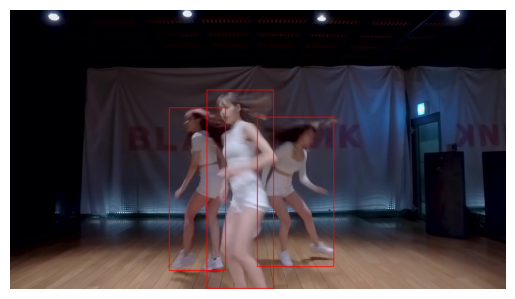

In [10]:
bboxes  = [(462, 280, 462 + 164,  280 + 467), (718, 307, 718 + 222, 307 + 429), (572 , 229, 572+ 193,  229 + 569)]
# bboxes 

# image_h, image_w = (800, 1440)
scale  = (1920/1440, 1080/800)



# Function to normalize bounding boxes
def normalize_bounding_boxes(bounding_boxes, original_width = 1440, original_height = 800):
    normalized_boxes = []
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        # Normalize coordinates
        norm_x_min = x_min / original_width
        norm_y_min = y_min / original_height
        norm_x_max = x_max / original_width
        norm_y_max = y_max / original_height
        normalized_boxes.append((norm_x_min, norm_y_min, norm_x_max, norm_y_max))
    return normalized_boxes

# Function to denormalize bounding boxes
def denormalize_bounding_boxes(normalized_boxes, new_width = 1920, new_height = 1080):
    denormalized_boxes = []
    for (norm_x_min, norm_y_min, norm_x_max, norm_y_max) in normalized_boxes:
        # Denormalize coordinates
        x_min = int(norm_x_min * new_width)
        y_min = int(norm_y_min * new_height)
        x_max = int(norm_x_max * new_width)
        y_max = int(norm_y_max * new_height)
        denormalized_boxes.append((x_min, y_min, x_max, y_max))
    return denormalized_boxes

import matplotlib.pyplot as plt
image_file = "datasets/dancetrack/val/dancetrack0004/img1/00000001.jpg"
import cv2


# Example function to draw bounding boxes on an image and show it
def draw_bounding_boxes(image_path, bounding_boxes):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # print(image)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib uses RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Loop through the bounding boxes and draw rectangles
    for box in bounding_boxes:
        # box is in the format (x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = box
        # Draw rectangle on the image
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
    
    # Show the image using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
    
# Function to scale bounding boxes to the new aspect ratio
def scale_bounding_boxes(bounding_boxes, old_width =1440, old_height = 800, new_width = 1920, new_height = 1080):
    scale_x = new_width / old_width
    scale_y = new_height / old_height
    
    scaled_boxes = []
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        # Scale the coordinates
        new_x_min = int(x_min * scale_x)
        new_y_min = int(y_min * scale_y)
        new_x_max = int(x_max * scale_x)
        new_y_max = int(y_max * scale_y)
        scaled_boxes.append((new_x_min, new_y_min, new_x_max, new_y_max))
    
    return scaled_boxes



# bboxes = normalize_bounding_boxes(bboxes)
# bboxes = denormalize_bounding_boxes(bboxes)
print("bounding boxes before : ", bboxes)
bboxes = scale_bounding_boxes(bboxes)
print(" bounding boxes now are : ", bboxes)
draw_bounding_boxes(image_file, bboxes)

In [3]:
bboxes  = [(462, 280, 462 + 164,  280 + 467), (718, 307, 718 + 222, 307 + 429), (572 , 229, 572+ 193,  229 + 569)]

bboxes_tlbr = bboxes
bboxes_tlbr
bboxes_scaled_tlbr = [[616, 378, 834, 1008], [957, 414, 1253, 993], [762, 309, 1020, 1077]]
bboxes_scaled_tlwh = [[616, 378, 834 - 616, 1008-378], [ 957, 414, 1253-957, 993-414], [762, 309, 1020-762, 1077-309]]
bboxes_scaled_tlwh


[[616, 378, 218, 630], [957, 414, 296, 579], [762, 309, 258, 768]]

In [9]:
import numpy as np
sequence = [[617, 379, 219, 630]]

sequence = np.array(sequence)
print("sequence is: ", sequence)
mean = 0
std_dev = 1
    # Generate Gaussian noise
noise = np.random.normal(mean, std_dev, sequence.shape)
    
    # Add the noise to the sequence
noisy_sequence = sequence + noise
print("noise sequence : ", noisy_sequence)

sequence is:  [[617 379 219 630]]
noise sequence :  [[617.31509425 378.62166881 220.18097249 631.77253753]]


In [11]:
import cv2
import numpy as np
import os
def draw_bounding_boxes(image, boxes, color, label):
    """
    Draw bounding boxes on the image.
    
    image: The image on which to draw the bounding boxes
    boxes: List of bounding boxes with format (x_min, y_min, width, height)
    color: Bounding box color (e.g., (255, 0, 0) for blue)
    label: Text label to display (e.g., 'Tracking' or 'Ground Truth')
    """
    for box in boxes:
        x_min, y_min, width, height = box[:4]
        # Draw rectangle on the image
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), color, 2)
        # Display label near the top left corner of the bounding box
        # cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        label_with_id = f"{label} ID: {int(track_id)}"
        cv2.putText(image, " ",(int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


def visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_video_path, fps=30):
    """
    Visualizes tracking results and ground truth data on images and saves them as a video.
    
    sequence_folder: Folder containing image sequence
    tracking_file: Path to the file containing tracking data
    ground_truth_file: Path to the file containing ground truth data
    output_video_path: Path to save the resulting video
    fps: Frames per second for the output video
    """
    # Read the tracking and ground truth files
    tracking_data = np.loadtxt(tracking_file, delimiter=',')
    ground_truth_data = np.loadtxt(ground_truth_file, delimiter=',')
    
    frame_ids = set(tracking_data[:, 0])  # Set of unique frame_ids
    frame_ids = sorted(frame_ids)  # Sort frame_ids for sequential video

    # Get the size of the first image to define video properties
    first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):08d}.jpg')
    first_image = cv2.imread(first_img_path)
    if first_image is None:
        raise FileNotFoundError(f"Image not found: {first_img_path}")

    height, width, _ = first_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec for MP4 format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_id in frame_ids:
        # Read the corresponding image
        img_path = os.path.join(sequence_folder, f'{int(frame_id):08d}.jpg')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found: {img_path}")
            continue

        # Extract tracking bounding boxes for the current frame
        tracking_boxes = tracking_data[tracking_data[:, 0] == frame_id]
        tracking_boxes = tracking_boxes[:, 1:6]  # Extract x_min, y_min, width, height

        # Extract ground truth bounding boxes for the current frame
        ground_truth_boxes = ground_truth_data[ground_truth_data[:, 0] == frame_id]
        ground_truth_boxes = ground_truth_boxes[:, 1:6]  # Extract x_min, y_min, width, height

        # Draw tracking boxes (in blue) and ground truth boxes (in green)
        draw_bounding_boxes(image, tracking_boxes, color=(0, 0, 0), label='Tracking')
        draw_bounding_boxes(image, ground_truth_boxes, color=(255, 0, 0), label='Ground Truth')

        # Write the frame to the video
        video_writer.write(image)

        print(f"Processed frame {int(frame_id)} and added to the video.")

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")# sequence_folder
# Example usage
sequence_folder = 'datasets/dancetrack/val/dancetrack0005/img1'  # Folder containing images
tracking_file = 'YOLOX_outputs/testing_oct7/testing_oct7_val/dancetrack0005.txt'  # File containing tracking data
ground_truth_file = 'datasets/dancetrack/val/dancetrack0005/gt/gt.txt'  # File containing ground truth data
output_folder = 'Oct_11_output_visualized_video_dancetrack0005.mp4'  # Folder to save visualized images

visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_folder)

Processed frame 1 and added to the video.
Processed frame 2 and added to the video.
Processed frame 3 and added to the video.
Processed frame 4 and added to the video.
Processed frame 5 and added to the video.
Processed frame 6 and added to the video.
Processed frame 7 and added to the video.
Processed frame 8 and added to the video.
Processed frame 9 and added to the video.
Processed frame 10 and added to the video.
Processed frame 11 and added to the video.
Processed frame 12 and added to the video.
Processed frame 13 and added to the video.
Processed frame 14 and added to the video.
Processed frame 15 and added to the video.
Processed frame 16 and added to the video.
Processed frame 17 and added to the video.
Processed frame 18 and added to the video.
Processed frame 19 and added to the video.
Processed frame 20 and added to the video.
Processed frame 21 and added to the video.
Processed frame 22 and added to the video.
Processed frame 23 and added to the video.
Processed frame 24 a

In [3]:
import numpy as np
import torch.nn as nn
import torch

input_seq = np.array([[[763, 309, 257, 768,],
 [727, 316, 301, 761,],
 [713, 322, 316, 755,],
 [628, 330, 406, 745,],
 [655, 355, 380, 718,],
 [609, 370, 464, 704,],
 [561, 385, 521, 684,],
 [521, 403, 569, 672,],
 [569, 443, 536, 630,],
 [743, 438, 327, 640]],
 [[536, 441, 312, 629],
 [458, 443, 426, 630],
 [487, 519, 420, 520],
 [530, 552, 371, 478],
 [549, 630, 343, 393],
 [472, 637, 392, 378],
 [461, 636, 438, 370],
 [514, 628, 408, 366],
 [537, 623, 315, 363],
 [818, 587, 131, 240]],
 
 [[957, 414, 296, 579],
 [957, 417, 319, 576],
 [963, 422, 308, 570],
 [952, 430, 322, 560],
 [950, 461, 302, 527],
 [849, 535, 441, 432],
 [720, 564, 587, 440],
 [763, 587, 549, 441],
 [840, 628, 448, 320],
 [893, 639, 388, 302]],
 
 [[763, 309, 257, 768],
 [727, 316, 301, 761],
 [713, 322, 316, 755],
 [628, 330, 406, 745],
 [655, 355, 380, 718],
 [609, 370, 464, 704],
 [0,   0,   0,   0],
 [0,   0,   0,   0],
 [0,   0,   0,   0],
 [0,   0,   0,   0]]], dtype = float)

from models_mamba import FullModelMambaBBox
input_size = 4
# Model parameters
# model_type = model_type
# dataset_name = dataset_name
input_size = 4  # Bounding box has 4 coordinates: [x, y, width, height]
hidden_size = 64 ## This one is used for LSTM NEtwork which I tried
output_size = 4  # Output also has 4 coordinates
num_layers = 4## For LSTM
embedding_dim = 128 ## For Mamba
num_blocks = 3 ## For Mamba
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# self.best_model_name  = "best_model_bbox_{}_variable_{}.pth".format(self.dataset_name, self.model_type)
best_model_name = "best_model_bbox_dancetrack_variable_bi-mamba_04_October.pth"

# print("model type is :",model_type)
# exit(0)

# if model_type == "bi-mamba" or model_type == "vanilla-mamba":
model = FullModelMambaBBox(input_size, embedding_dim, num_blocks, output_size, mamba_type =  "bi-mamba").to(device)
    # exit(0)

# print(" model to be loaded is : ", self.best_model_name)
model.load_state_dict(torch.load(best_model_name))  # Load the best model



<All keys matched successfully>

In [4]:

def denormalize_bbox(bboxes, img_size):
    """
    Denormalize bounding boxes to original scale. This converts it back to MOT Format as well. 
    """
    # bbox[:, 0] *= image_width  # Denormalize center_x
    # bbox[:, 1] *= image_height  # Denormalize center_y
    # bbox[:, 2] *= image_width  # Denormalize width
    # bbox[:, 3] *= image_height  # Denormalize height
    
    # # Convert back from (center_x, center_y, width, height) to (left, top, width, height)
    # bbox[:, 0] -= bbox[:, 2] / 2  # left = center_x - width/2
    # bbox[:, 1] -= bbox[:, 3] / 2  # top = center_y - height/2
    
    # return bbox
    # assert bboxes.shape[1:] == (4,), "Input bounding boxes should be in (center_x, center_y, width, height) format."
    # print("The image size used in DENORMALIZATION is: ", img_size)
    # Apply denormalization for each prediction
    img_h, img_w = img_size[0].item(), img_size[1].item()          ### SETTING IMAGE SIZE LIKE THIS IS NOT A MISTAKE
    print(" image height : {} and image width : {}".format(img_h, img_w))
    bboxes[:, 0] *= img_w   # Denormalize center_x
    bboxes[:, 1] *= img_h  # Denormalize center_y
    bboxes[:, 2] *= img_w   # Denormalize width
    bboxes[:, 3] *= img_h  # Denormalize height

    # Convert from (center_x, center_y, width, height) to (left, top, width, height)
    bboxes[:, 0] -= bboxes[:, 2] / 2  # left = center_x - width / 2
    bboxes[:, 1] -= bboxes[:, 3] / 2  # top = center_y - height / 2
    
    return bboxes
    
    
def normalize_yolo_bbox(bboxes, image_size):
    
    
    # print(" image size is : ", image_size)
    #### This function first converts the data from xywh format to YOLO Format, then nomralize it to process the model
    img_h, img_w = image_size[0], image_size[1]  # Image dimensions (height, width)

    # print("image height and width used for normalization is : {} , {}".format(img_h, img_w))
# Convert xywh to center-based YOLO format by adjusting the (x, y) to be at the center
    bboxes[..., 0] = bboxes[..., 0] + bboxes[..., 2] / 2  # Update x to center x
    bboxes[..., 1] = bboxes[..., 1] + bboxes[..., 3] / 2  # Update y to center y

    # Normalize the bounding boxes
    bboxes[..., 0] /= img_w  # Normalize center x
    bboxes[..., 1] /= img_h  # Normalize center y
    bboxes[..., 2] /= img_w  # Normalize width
    bboxes[..., 3] /= img_h  # Normalize height

    return bboxes
    

In [5]:
img_size = [torch.Tensor([1080]), torch.Tensor([1920])]
print(" tracklet detections shape : ", input_seq.shape)
print(" tracklet detections before normalization : \n", input_seq)
img_h, img_w = img_size[0].to(device), img_size[1].to(device)

tracklet_detections = normalize_yolo_bbox(input_seq, img_size)
print(" tracklet before prediction is : ", tracklet_detections)
        
tracklet_detections = torch.from_numpy(tracklet_detections).float().to(device)
        
print("tracklet detections are :", tracklet_detections)
with torch.no_grad():
    
    predictions = model(tracklet_detections)
    # print(" predictions type if : ", type(predictions))
    predicted_bbox  = predictions.cpu().numpy()
    
    print(" predicted_bbox is : ", predicted_bbox)
    # print("image size is : ", img_size)
    predicted_bbox = denormalize_bbox(predictions.cpu().numpy(), img_size)            
    print(" predicted box is :\n", predicted_bbox)
        

 tracklet detections shape :  (4, 10, 4)
 tracklet detections before normalization : 
 [[[763. 309. 257. 768.]
  [727. 316. 301. 761.]
  [713. 322. 316. 755.]
  [628. 330. 406. 745.]
  [655. 355. 380. 718.]
  [609. 370. 464. 704.]
  [561. 385. 521. 684.]
  [521. 403. 569. 672.]
  [569. 443. 536. 630.]
  [743. 438. 327. 640.]]

 [[536. 441. 312. 629.]
  [458. 443. 426. 630.]
  [487. 519. 420. 520.]
  [530. 552. 371. 478.]
  [549. 630. 343. 393.]
  [472. 637. 392. 378.]
  [461. 636. 438. 370.]
  [514. 628. 408. 366.]
  [537. 623. 315. 363.]
  [818. 587. 131. 240.]]

 [[957. 414. 296. 579.]
  [957. 417. 319. 576.]
  [963. 422. 308. 570.]
  [952. 430. 322. 560.]
  [950. 461. 302. 527.]
  [849. 535. 441. 432.]
  [720. 564. 587. 440.]
  [763. 587. 549. 441.]
  [840. 628. 448. 320.]
  [893. 639. 388. 302.]]

 [[763. 309. 257. 768.]
  [727. 316. 301. 761.]
  [713. 322. 316. 755.]
  [628. 330. 406. 745.]
  [655. 355. 380. 718.]
  [609. 370. 464. 704.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.  

In [18]:
import cv2
import numpy as np
import os

def draw_bounding_boxes(image, boxes, color, label):
    """
    Draw bounding boxes and track IDs on the image.
    
    image: The image on which to draw the bounding boxes
    boxes: List of bounding boxes with format (track_id, x_min, y_min, width, height)
    color: Bounding box color (e.g., (255, 0, 0) for blue)
    label: Text label to display (e.g., 'Tracking' or 'Ground Truth')
    """
    for box in boxes:
        track_id, x_min, y_min, width, height = box
        # Draw rectangle on the image
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), color, 2)
        # Display track ID and label near the top left corner of the bounding box
        label_with_id = f"ID: {int(track_id)}"
        if label == "Tracking":
            cv2.putText(image, label_with_id, (int(x_min + width - 10), int(y_min ) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        else:
            cv2.putText(image, label_with_id, (int(x_min- 10), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


def visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_video_path, fps=30):
    """
    Visualizes tracking results and ground truth data on images and saves them as a video.
    
    sequence_folder: Folder containing image sequence
    tracking_file: Path to the file containing tracking data
    ground_truth_file: Path to the file containing ground truth data
    output_video_path: Path to save the resulting video
    fps: Frames per second for the output video
    """
    # Read the tracking and ground truth files
    tracking_data = np.loadtxt(tracking_file, delimiter=',')
    ground_truth_data = np.loadtxt(ground_truth_file, delimiter=',')

    frame_ids = set(tracking_data[:, 0])  # Set of unique frame_ids
    frame_ids = sorted(frame_ids)  # Sort frame_ids for sequential video

    # Get the size of the first image to define video properties
    first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):08d}.jpg')
    first_image = cv2.imread(first_img_path)
    if first_image is None:
        raise FileNotFoundError(f"Image not found: {first_img_path}")

    height, width, _ = first_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec for MP4 format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_id in frame_ids:
        # Read the corresponding image
        img_path = os.path.join(sequence_folder, f'{int(frame_id):08d}.jpg')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found: {img_path}")
            continue

        # Extract tracking bounding boxes for the current frame
        tracking_boxes = tracking_data[tracking_data[:, 0] == frame_id]
        tracking_boxes = tracking_boxes[:, 1:6]  # Extract track_id, x_min, y_min, width, height

        # Extract ground truth bounding boxes for the current frame
        ground_truth_boxes = ground_truth_data[ground_truth_data[:, 0] == frame_id]
        ground_truth_boxes = ground_truth_boxes[:, 1:6]  # Extract track_id, x_min, y_min, width, height

        # Draw tracking boxes (in blue) and ground truth boxes (in green)
        draw_bounding_boxes(image, tracking_boxes, color=(0, 0, 0), label='Tracking')
        draw_bounding_boxes(image, ground_truth_boxes, color=(0, 255, 0), label='Ground Truth')

        # Write the frame to the video
        video_writer.write(image)

        print(f"Processed frame {int(frame_id)} and added to the video.")

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")

# Example usage
sequence_folder = 'datasets/dancetrack/val/dancetrack0004/img1'  # Folder containing images
tracking_file = 'YOLOX_outputs/testing_oct7/testing_oct7_val/dancetrack0004.txt'  # File containing tracking data
ground_truth_file = 'datasets/dancetrack/val/dancetrack0004/gt/gt.txt'  # File containing ground truth data
output_folder = 'Oct_11_output_visualized_video_dancetrack0004.mp4'  # Folder to save visualized images

visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_folder)

Processed frame 1 and added to the video.
Processed frame 2 and added to the video.
Processed frame 3 and added to the video.
Processed frame 4 and added to the video.
Processed frame 5 and added to the video.
Processed frame 6 and added to the video.
Processed frame 7 and added to the video.
Processed frame 8 and added to the video.
Processed frame 9 and added to the video.
Processed frame 10 and added to the video.
Processed frame 11 and added to the video.
Processed frame 12 and added to the video.
Processed frame 13 and added to the video.
Processed frame 14 and added to the video.
Processed frame 15 and added to the video.
Processed frame 16 and added to the video.
Processed frame 17 and added to the video.
Processed frame 18 and added to the video.
Processed frame 19 and added to the video.
Processed frame 20 and added to the video.
Processed frame 21 and added to the video.
Processed frame 22 and added to the video.
Processed frame 23 and added to the video.
Processed frame 24 a